# CSE-CIC-IDS2018 Web Attack Detection


This notebook aims to tackle the idea of web attack detection using various classification models.

The dataset used can be found here: https://www.unb.ca/cic/datasets/ids-2018.html







In [77]:
from __future__ import division
import pandas as pd
import numpy as np
import lightgbm as lgb
import os
import pickle

from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import recall_score, precision_score, f1_score, average_precision_score
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_curve
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.neural_network import MLPClassifier
import time

from imblearn.over_sampling import ADASYN
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
import plotly.graph_objs as go

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

%matplotlib inline

In [78]:
df = pd.read_pickle('cleaned_df2.pkl')

## Comparison of Five Major Features

**Fwd Pkt Len Max**  
This feature denotes the maximum size of a packet in the forward direction. When an attacker is launching something like a brute force attack or a SQL injection, the packet size on average should be large. A brute force attacker would want to send numerous attempts to password hack a site and a SQL injection would likely contain more instructions on average in order to properly insert malicious queries.

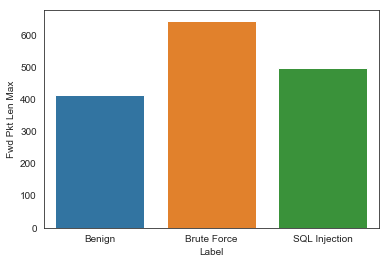

In [79]:
visual_cols = ['Fwd Pkt Len Max', 'Fwd IAT Max', 'Bwd IAT Min', 'ECE Flag Cnt', 'RST Flag Cnt']
colors = ['#03A9F4', '#FF5722', '#EC407A']
line_names = ['Benign', 'Brute Force', 'SQL Injection']
avg_pkt = df.groupby(['Label']).agg({'Fwd Pkt Len Max':'mean'}) 
avg_pkt.reset_index(inplace=True)
ax = sns.barplot(x='Label', y='Fwd Pkt Len Max', data=avg_pkt)

**Fwd IAT Max**  
This feature denotes the maximum time between two packets sent in the forward direction. We can see that on average, benign flows tend to have a longer time between two packets while attacker type packets tend to have lower times. This makes sense because intuitively, attackers would want to quickly hack in and steal information as fast as possible before the victim notices or an IP trace can occur.

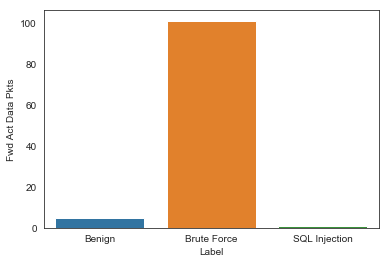

In [80]:
avg_pkt = df.groupby(['Label']).agg({'Fwd Act Data Pkts':'median'}) 
avg_pkt.reset_index(inplace=True)
ax = sns.barplot(x='Label', y='Fwd Act Data Pkts', data=avg_pkt)

**Bwd IAT Min**  
This feature denotes the minimum time between two packets in the backward direction. When someone manages to successfully hack into a company network or database, the attacker will want to capture as much information as possible. This tactic is reflected in the data here as you can see that there is nearly no delay in packets in the backward direction here for malicious packets.

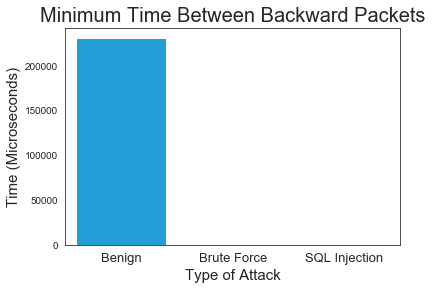

In [81]:

avg_pkt = df.groupby(['Label']).agg({'Bwd IAT Min':'mean'}) 
avg_pkt.reset_index(inplace=True)
ax = sns.barplot(x='Label', y='Bwd IAT Min', data=avg_pkt, palette=colors)
ax.set_xticklabels(line_names, size=13);
ax.set_ylabel('Time (Microseconds)', size=15)
ax.set_xlabel('Type of Attack', size=15)
ax.set_title('Minimum Time Between Backward Packets', size=20);
plt.savefig('bwiat', bbox_inches ='tight', dpi = 400)

In [82]:
avg_pkt

,Label,Bwd IAT Min
0,Benign,230709.753802
1,Brute Force,520.227154
2,SQL Injection,1551.103448


**ECE Flag Cnt**  
This feature denotes the number of ECE flags sent. The ECE flag is essentially an empty packet used to tell the sender to reduce the amount of information they are sending because it is causing congestion. Clearly given the nature of web attacks, attackers tend to overwhelm servers with requests so this feature will play a key role in distinguishing attacking packets from benign ones.

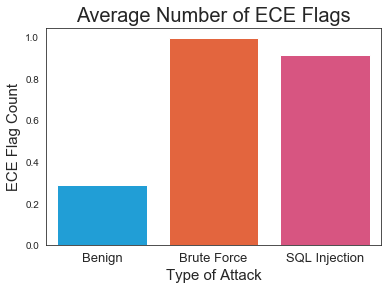

In [83]:

avg_pkt = df.groupby(['Label']).agg({'ECE Flag Cnt':'mean'}) 
avg_pkt.reset_index(inplace=True)
ax = sns.barplot(x='Label', y='ECE Flag Cnt', data=avg_pkt, palette=colors)
ax.set_xticklabels(line_names, size=13);
ax.set_ylabel('ECE Flag Count', size=15)
ax.set_xlabel('Type of Attack', size=15)
ax.set_title('Average Number of ECE Flags', size=20);
plt.savefig('ece', bbox_inches ='tight', dpi = 400)

**RST Flag Cnt**  
The RST Flag is a packet sent from the receiver to the sender when the host has received a packet it was not expecting. An RST flag terminates the connection and the sender will have to re-establish the connection to continue sending packets. It is quite rare but not impossible for RST flags to be sent in response to benign requests. In contrast, malicious attacks can easily be detected by checking if a server is sending many RST flags.

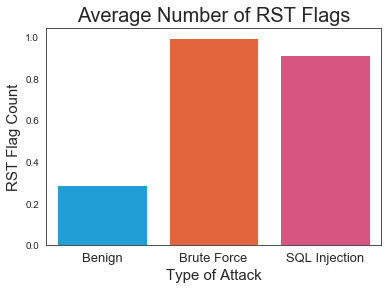

In [84]:
sns.set_style('white')

avg_pkt = df.groupby(['Label']).agg({'RST Flag Cnt':'mean'}) 
avg_pkt.reset_index(inplace=True)
ax = sns.barplot(x='Label', y='RST Flag Cnt', data=avg_pkt, palette=colors)
ax.set_xticklabels(line_names, size=13);
ax.set_ylabel('RST Flag Count', size=15)
ax.set_xlabel('Type of Attack', size=15)
ax.set_title('Average Number of RST Flags', size=20);
plt.savefig('rst', bbox_inches ='tight', dpi = 400)

In [85]:
y = df['Target'] 
y1 = y.copy()
df.drop(columns=['Label', 'Target'], inplace=True) 

In [86]:
X, X_test, y, y_test = train_test_split(df, y1, test_size=0.20, random_state=32, stratify = y1)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=52, stratify = y)

In [87]:
pd.Series(y_train).value_counts()

0    505157
1       230
2        35
Name: Target, dtype: int64

In [88]:
X_train.columns

Index(['Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'Fwd Pkt Len Max',
       'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max',
       'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow Byts/s',
       'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std',
       'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Fwd Header Len',
       'Bwd Header Len', 'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Max',
       'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var', 'SYN Flag Cnt',
       'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt',
       'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg', 'Fwd Seg Size Avg',
       'Bwd Seg Size Avg', 'Init Fwd Win Byts', 'Init Bwd Win Byts',
       'Fwd Act Data Pkts', 'Fwd Seg Size Min', 'Active Mean', 'Active Std',
       'Active Max', 'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max'

In [89]:
df.columns

Index(['Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'Fwd Pkt Len Max',
       'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max',
       'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow Byts/s',
       'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std',
       'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Fwd Header Len',
       'Bwd Header Len', 'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Max',
       'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var', 'SYN Flag Cnt',
       'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt',
       'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg', 'Fwd Seg Size Avg',
       'Bwd Seg Size Avg', 'Init Fwd Win Byts', 'Init Bwd Win Byts',
       'Fwd Act Data Pkts', 'Fwd Seg Size Min', 'Active Mean', 'Active Std',
       'Active Max', 'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max'

## List of Models
1. Logistic Regression
2. Random Forest
3. Decision Tree
4. LightGBM
5. Neural Net
6. XGBoost?

In [90]:
# X_adasyn, y_adasyn = ADASYN(random_state=71).fit_sample(X_train, y_train)
# X_adasyn_df = pd.DataFrame(X_adasyn, columns=X_train.columns) 
# scaler = StandardScaler()  
# X_adasyn_scaled = scaler.fit_transform(X_adasyn)
# X_val_scaled = scaler.transform(X_val.values)
# X_test_scaled = scaler.transform(X_test.values)

In [91]:
def print_confusion_matrix(conf_mat):
    classes = ['Benign', 'BruteForce', 'SQL Injection']
    new_classes = ['SQL Injection', 'BruteForce', 'Benign'] 
    df_cm = pd.DataFrame(conf_mat, index=new_classes,  columns=classes)
    temp = df_cm.iloc[0].copy()
    df_cm.iloc[0] = df_cm.iloc[2]
    df_cm.iloc[2] = temp  
    fig = plt.figure(figsize=(10,5))
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    bottom, top = heatmap.get_ylim()
    heatmap.set_ylim(bottom + 0.5, top - 0.5)
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=15)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=15)
    plt.ylabel('True label', size=18)
    plt.xlabel('Predicted label', size=18);

## RandomForest Classifier

In [92]:
class_labels = ['Benign', 'Brute Force', 'SQL Injection']

In [93]:
filename = 'best_rf.pkl' 
loaded_model = pickle.load(open(filename, 'rb'))
rf_y_val = loaded_model.predict(X_val)
print(classification_report(y_val, rf_y_val, target_names=class_labels))

               precision    recall  f1-score   support

       Benign       1.00      1.00      1.00    168386
  Brute Force       1.00      0.99      0.99        76
SQL Injection       0.92      1.00      0.96        12

     accuracy                           1.00    168474
    macro avg       0.97      1.00      0.98    168474
 weighted avg       1.00      1.00      1.00    168474



In [94]:
rf_y_test = loaded_model.predict(X_test)
print(classification_report(y_test, rf_y_test, target_names=class_labels))

               precision    recall  f1-score   support

       Benign       1.00      1.00      1.00    168386
  Brute Force       0.99      0.97      0.98        77
SQL Injection       0.91      0.91      0.91        11

     accuracy                           1.00    168474
    macro avg       0.97      0.96      0.96    168474
 weighted avg       1.00      1.00      1.00    168474



In [95]:
clf = RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=100, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=180,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

clf.fit(X_train,y_train)
clf_y_val = clf.predict(X_val)
print(classification_report(y_val, clf_y_val, target_names=class_labels))

               precision    recall  f1-score   support

       Benign       1.00      1.00      1.00    168386
  Brute Force       0.97      0.97      0.97        76
SQL Injection       0.90      0.75      0.82        12

     accuracy                           1.00    168474
    macro avg       0.96      0.91      0.93    168474
 weighted avg       1.00      1.00      1.00    168474



In [96]:
clf

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=100, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=180,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [97]:
cl_y_test = clf.predict(X_test) 
print(classification_report(y_test, cl_y_test, target_names=class_labels))

               precision    recall  f1-score   support

       Benign       1.00      1.00      1.00    168386
  Brute Force       0.97      0.95      0.96        77
SQL Injection       0.82      0.82      0.82        11

     accuracy                           1.00    168474
    macro avg       0.93      0.92      0.93    168474
 weighted avg       1.00      1.00      1.00    168474



In [98]:
confusion_matrix(y_val,rf_y_val)  

array([[168386,      0,      0],
       [     0,     75,      1],
       [     0,      0,     12]])

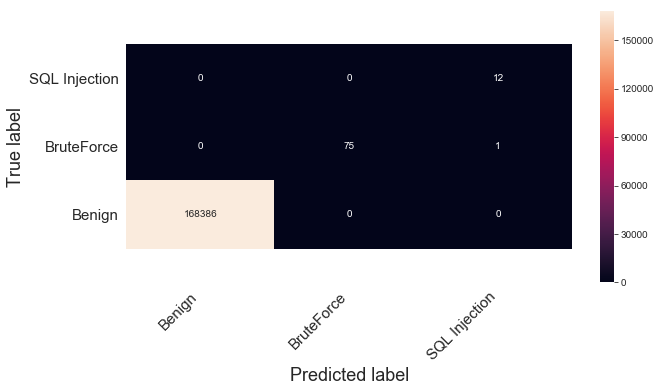

In [99]:
conf_mat = confusion_matrix(y_val,rf_y_val) 
print_confusion_matrix(conf_mat)  

In [100]:
def print_confusion_matrix2(conf_mat):
    classes = ['Benign', 'BruteForce', 'SQL Injection']
    #new_classes = ['SQL Injection', 'BruteForce', 'Benign'] 
    df_cm = pd.DataFrame(conf_mat, index=classes,  columns=classes)
   # temp = df_cm.iloc[0].copy()
    #df_cm.iloc[0] = df_cm.iloc[2]
    #df_cm.iloc[2] = temp  
    fig = plt.figure(figsize=(10,5))
    heatmap = sns.heatmap(df_cm, cmap=plt.cm.copper, annot=True, fmt="d")
    bottom, top = heatmap.get_ylim()
    heatmap.set_ylim(bottom + 0.5, top - 0.5)
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=15)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=15)
    plt.ylabel('True label', size=18)
    plt.xlabel('Predicted label', size=18);
    plt.title('Random Forest Confusion Matrix', size=20)
    plt.savefig('conf_mat', bbox_inches ='tight', dpi = 400)

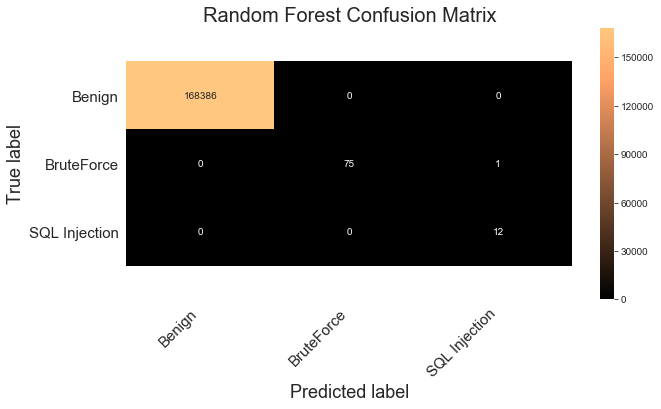

In [101]:
conf_mat = confusion_matrix(y_val,rf_y_val) 
print_confusion_matrix2(conf_mat)  

In [102]:
feature_importances = pd.DataFrame(index=X_train.columns.tolist())
feature_importances['Weight'] = loaded_model.feature_importances_ 
feature_importances.sort_values(by=['Weight'], ascending=False)

,Weight
Fwd Act Data Pkts,0.100357
RST Flag Cnt,0.065915
ECE Flag Cnt,0.065657
Bwd Pkt Len Max,0.051718
Bwd Seg Size Avg,0.050163
Bwd Pkt Len Mean,0.043064
Pkt Len Max,0.041216
Fwd Pkt Len Max,0.038901
Pkt Len Var,0.036032
Tot Fwd Pkts,0.032570


## RandomSearchCV 
This will help me get a better idea of range of good hyperarameters so I can do a GridSearch after.

In [103]:
# # Hyperparameters
# n_estimators = [int(x) for x in np.linspace(start = 10, stop = 250, num = 25)]
# max_features = ['auto', 'sqrt']
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)
# min_samples_split = [2, 5, 10]
# min_samples_leaf = [1, 2, 4]
# bootstrap = [True, False]

# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}

# rf = RandomForestClassifier(n_jobs=-1)
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# rf_random.fit(X, y)

In [104]:
# params = rf_random.best_params_

# best_rf = rf_random.best_estimator_
# best_rf.fit(X_train, y_train)
# rf_y_val = best_rf.predict(X_val)
# print(classification_report(y_val, rf_y_val, target_names=class_labels))

In [105]:
#with open('best_rf.pkl', 'wb') as model:
 #   pickle.dump(best_rf, model)    

In [106]:
# rf_classifier = RandomForestClassifier(n_estimators=100, n_jobs=-1)
# rf_classifier.fit(X_train, y_train)
# rf_y_val = rf_classifier.predict(X_val)
# print(classification_report(y_val, rf_y_val, target_names=class_labels))

In [107]:
# feature_importances = pd.DataFrame(index=X_train.columns.tolist())
# feature_importances['Weight'] = rf_classifier.feature_importances_ 
# feature_importances.sort_values(by=['Weight'], ascending=False)

## DecisionTree Classifier

Max_leaf nodes will reduce overfitting

**With ADASYN Oversampling**

In [108]:
dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(X_train, y_train)
dt_y_val = dt_classifier.predict(X_val) 
print(classification_report(y_val, dt_y_val, target_names=class_labels)) 

               precision    recall  f1-score   support

       Benign       1.00      1.00      1.00    168386
  Brute Force       0.97      0.99      0.98        76
SQL Injection       0.91      0.83      0.87        12

     accuracy                           1.00    168474
    macro avg       0.96      0.94      0.95    168474
 weighted avg       1.00      1.00      1.00    168474



In [75]:
dt_y_test = dt_classifier.predict(X_test)
print(classification_report(y_test, dt_y_test, target_names=class_labels))

               precision    recall  f1-score   support

       Benign       1.00      1.00      1.00    168386
  Brute Force       0.94      0.96      0.95        77
SQL Injection       0.60      0.55      0.57        11

     accuracy                           1.00    168474
    macro avg       0.85      0.84      0.84    168474
 weighted avg       1.00      1.00      1.00    168474



In [76]:
from sklearn.metrics import fbeta_score
fbeta_score(y_val, dt_y_val, average='macro', beta=5)

0.9418484623745296

In [112]:
estimator = dt_classifier

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = X_train.columns,
                class_names = line_names,
                rounded = True, proportion = False, 
                precision = 2, filled = True)


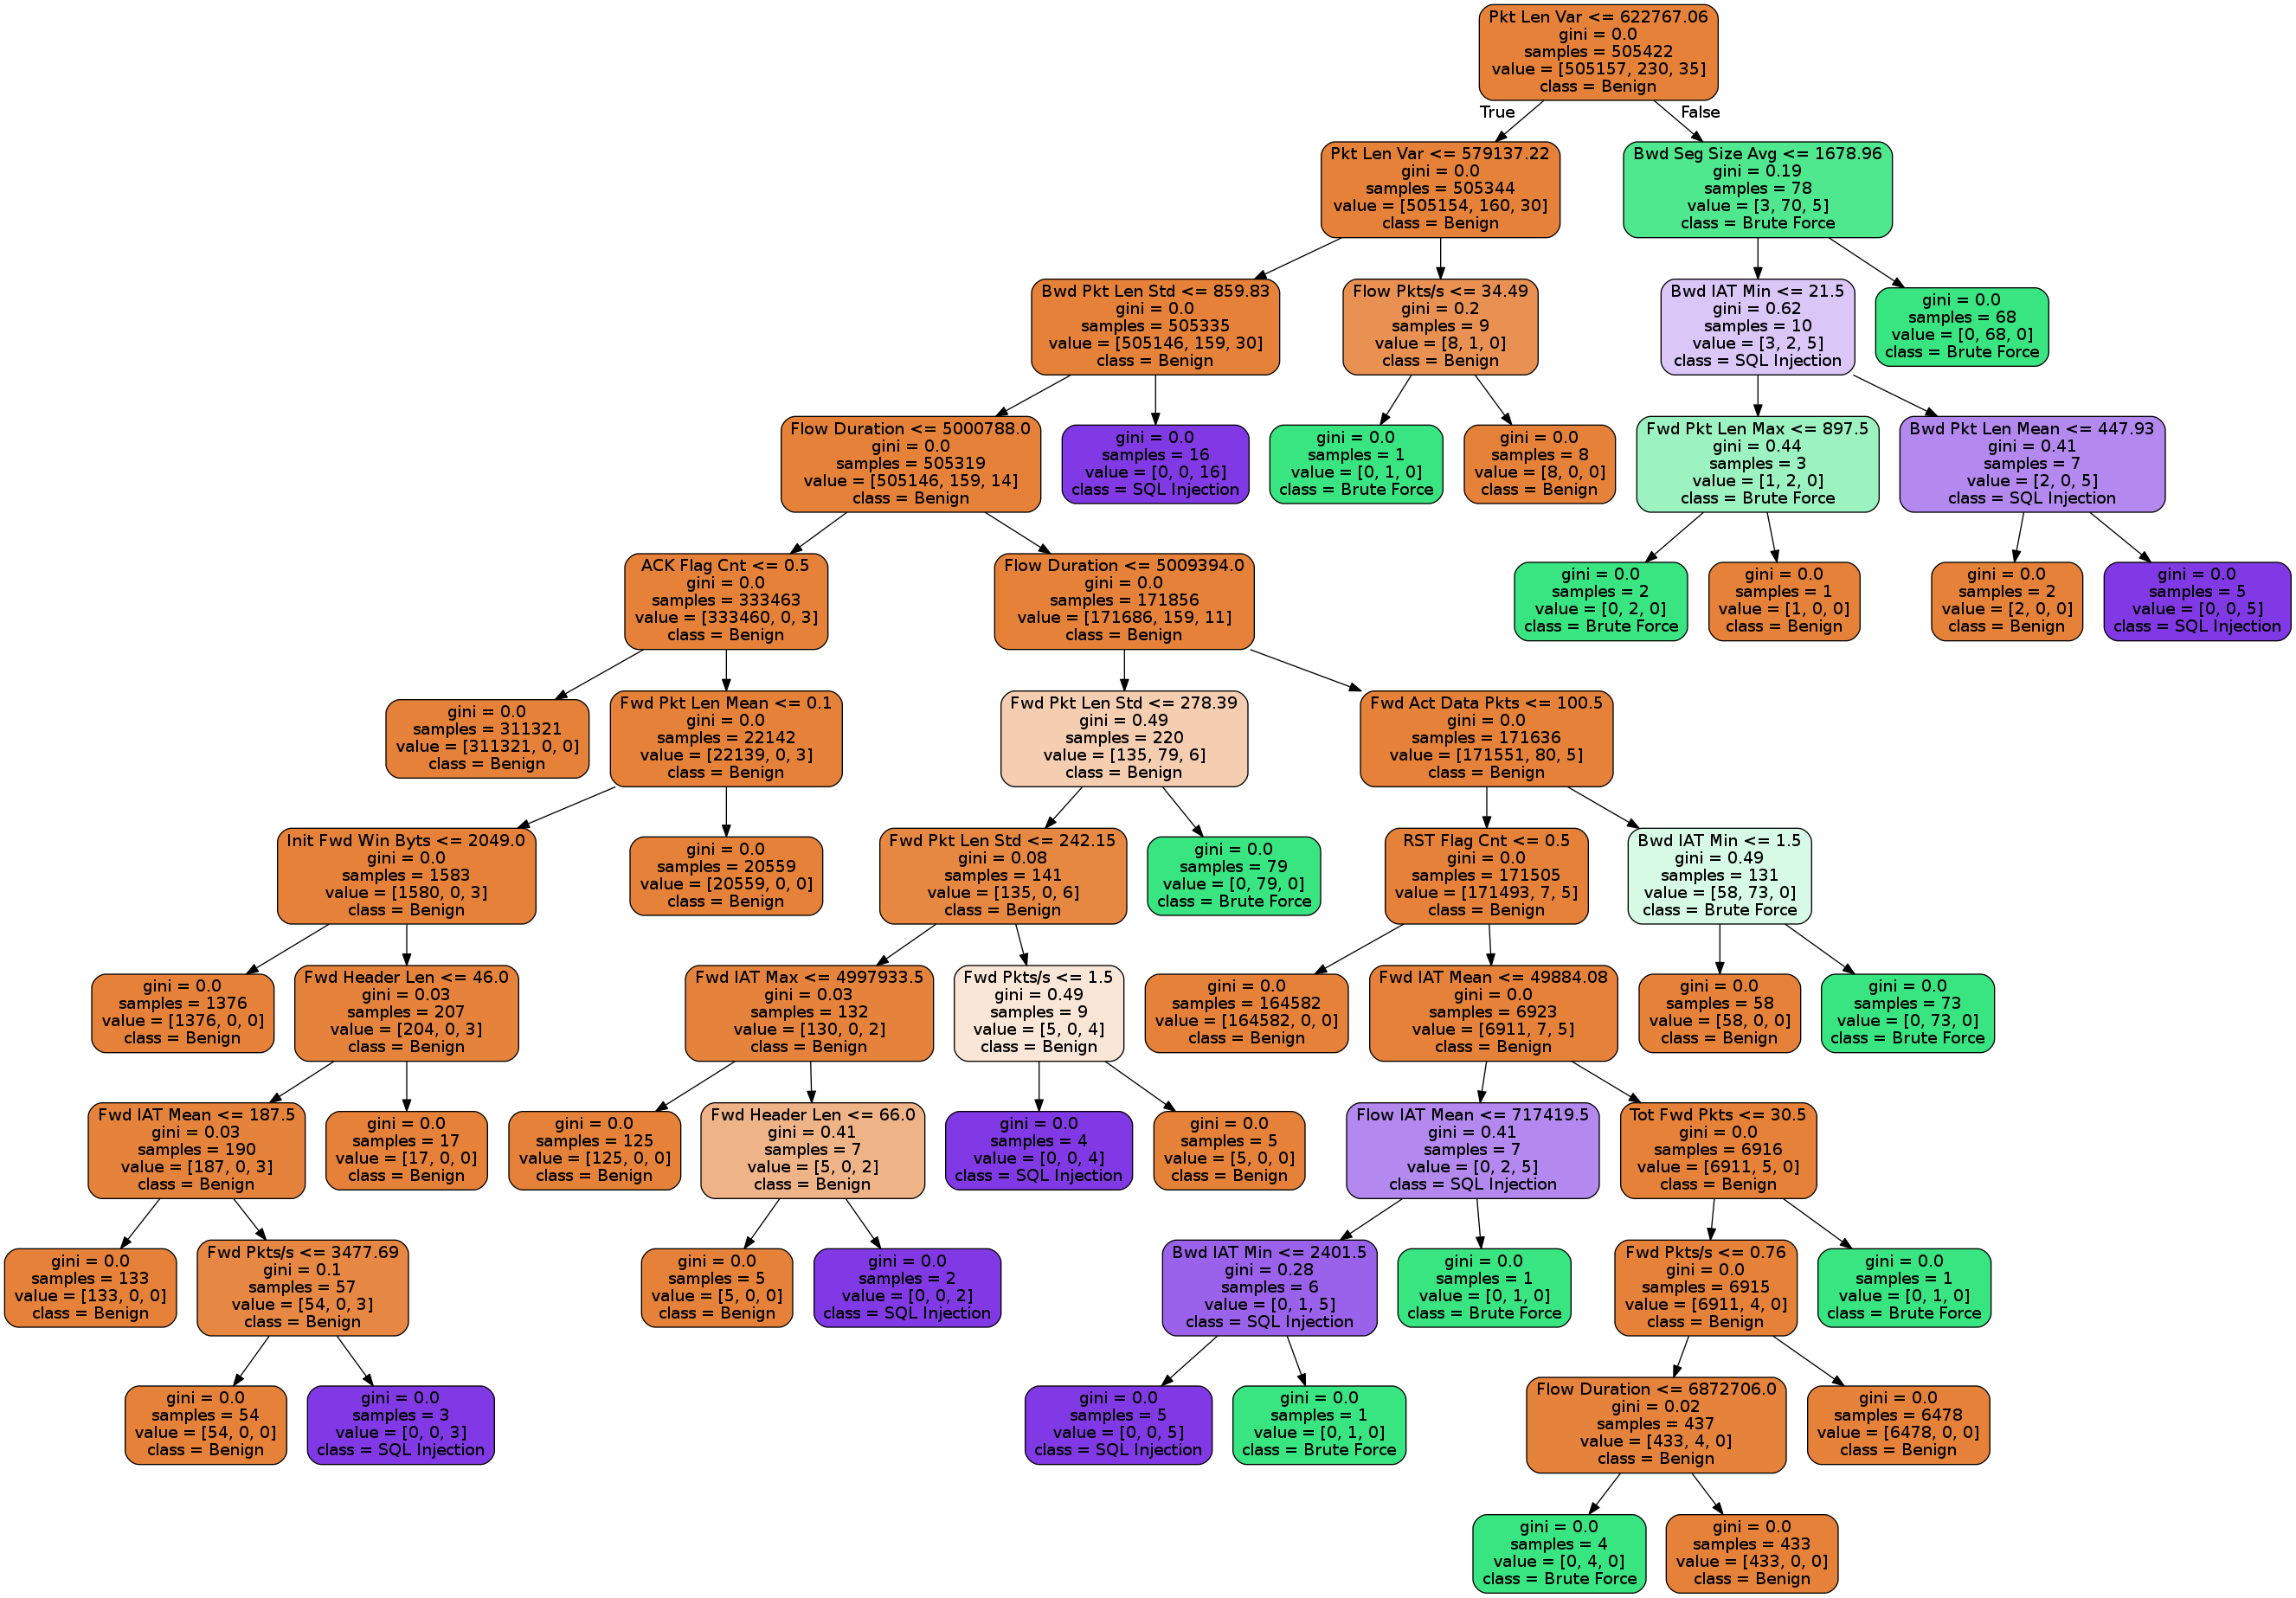

In [115]:
from IPython.display import Image
Image(filename = 'tree.png')

## LightGBM

In [32]:
lgb_model = lgb.LGBMClassifier(#boosting_type='rf',
                                   max_depth=-1,
                                   n_estimators=180,
                                   learning_rate=0.05,
                                   num_leaves=100,
                                   min_child_samples=10000,
                                   colsample_bytree = 0.5,
                                   objective='multiclass', 
                                   n_jobs=-1,
                                  # bagging_freq = 1,
                                  # bagging_fraction = 0.8,
                                  # bagging_seed = 71,
                                   random_state=43)

lgb_model.fit(X_train, y_train,  
                  eval_set=[(X_val, y_val)], 
                  verbose=100, early_stopping_rounds=100)

y_pred = lgb_model.predict(X_test.values)

Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_logloss: 0.000189999
Did not meet early stopping. Best iteration is:
[159]	valid_0's multi_logloss: 0.000158024


In [33]:
print(classification_report(y_test, y_pred, target_names=class_labels))

               precision    recall  f1-score   support

       Benign       1.00      1.00      1.00    168386
  Brute Force       0.95      0.97      0.96        77
SQL Injection       0.88      0.64      0.74        11

     accuracy                           1.00    168474
    macro avg       0.94      0.87      0.90    168474
 weighted avg       1.00      1.00      1.00    168474



## XGBoost

In [34]:
!pip install xgboost

In [35]:
from xgboost.sklearn import XGBClassifier 
xgb_model = XGBClassifier(n_jobs=-1, n_estimators=180)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_val) 
print(classification_report(y_val, y_pred, target_names=class_labels))

               precision    recall  f1-score   support

       Benign       1.00      1.00      1.00    168386
  Brute Force       0.96      0.99      0.97        76
SQL Injection       1.00      0.67      0.80        12

     accuracy                           1.00    168474
    macro avg       0.99      0.88      0.92    168474
 weighted avg       1.00      1.00      1.00    168474



In [36]:
xgb_y_test = xgb_model.predict(X_test) 
print(classification_report(y_test, xgb_y_test, target_names=class_labels))

               precision    recall  f1-score   support

       Benign       1.00      1.00      1.00    168386
  Brute Force       0.96      0.96      0.96        77
SQL Injection       0.86      0.55      0.67        11

     accuracy                           1.00    168474
    macro avg       0.94      0.84      0.88    168474
 weighted avg       1.00      1.00      1.00    168474



In [37]:
xgb_model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=180, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

## Prediction Time Comparison of Models

In [38]:
dt_classifier

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [91]:
def get_times(df, y1, model):
    X = df
    y = y1

    test_len = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
    len_list = []
    time_list = []
    for s in test_len:
        X_train, X_test, y_train, y_test = train_test_split(X, y1, test_size=s, random_state=16, stratify = y1)
        t0 = time.time()
        testing = model.predict(X_test)
        pred_time = time.time() - t0
        lengths = X_test.shape[0]
        len_list.append(lengths)
        time_list.append(pred_time)

    return len_list,time_list

In [40]:
lgb_model

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.5,
               importance_type='split', learning_rate=0.05, max_depth=-1,
               min_child_samples=10000, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=180, n_jobs=-1, num_leaves=100,
               objective='multiclass', random_state=43, reg_alpha=0.0,
               reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

## Scaling and Logistic Regression

In [41]:
scaler = StandardScaler() 
X_train_scaled = scaler.fit_transform(X_train.values) 
X_val_scaled = scaler.transform(X_val.values)
X_test_scaled = scaler.transform(X_test.values)

In [42]:
logistic = LogisticRegression(solver='lbfgs', multi_class='ovr', max_iter=1000, n_jobs=-1)
logistic.fit(X_train_scaled,y_train)
y_pred = logistic.predict(X_val_scaled)
print(classification_report(y_val, y_pred, target_names=class_labels))

               precision    recall  f1-score   support

       Benign       1.00      1.00      1.00    168386
  Brute Force       0.97      0.95      0.96        76
SQL Injection       0.78      0.58      0.67        12

     accuracy                           1.00    168474
    macro avg       0.92      0.84      0.88    168474
 weighted avg       1.00      1.00      1.00    168474



In [43]:
y_test_pred = logistic.predict(X_test_scaled)
print(classification_report(y_test, y_test_pred, target_names=class_labels))

               precision    recall  f1-score   support

       Benign       1.00      1.00      1.00    168386
  Brute Force       0.92      0.95      0.94        77
SQL Injection       1.00      0.36      0.53        11

     accuracy                           1.00    168474
    macro avg       0.97      0.77      0.82    168474
 weighted avg       1.00      1.00      1.00    168474



## Linear SVM

In [44]:
from sklearn.svm import LinearSVC
svm_model = LinearSVC(max_iter=100000)
svm_model.fit(X_train_scaled, y_train)
y_svm_pred = svm_model.predict(X_val_scaled)
print(classification_report(y_val, y_svm_pred, target_names=class_labels))

               precision    recall  f1-score   support

       Benign       1.00      1.00      1.00    168386
  Brute Force       0.97      0.95      0.96        76
SQL Injection       0.78      0.58      0.67        12

     accuracy                           1.00    168474
    macro avg       0.92      0.84      0.88    168474
 weighted avg       1.00      1.00      1.00    168474



In [45]:
y_svm_test = svm_model.predict(X_test_scaled)
print(classification_report(y_test, y_svm_test, target_names=class_labels))

               precision    recall  f1-score   support

       Benign       1.00      1.00      1.00    168386
  Brute Force       0.94      0.95      0.94        77
SQL Injection       1.00      0.45      0.62        11

     accuracy                           1.00    168474
    macro avg       0.98      0.80      0.86    168474
 weighted avg       1.00      1.00      1.00    168474



In [92]:
rf_lengths, rf_times = get_times(df,y1,loaded_model)
dt_lengths, dt_times = get_times(df,y1,dt_classifier)
xgb_lengths, xgb_times = get_times(df,y1,xgb_model)
lgb_lengths, lgb_times = get_times(df,y1,lgb_model)
log_lengths, log_times = get_times(df,y1,logistic)
svc_lengths, svc_times = get_times(df,y1,svm_model)

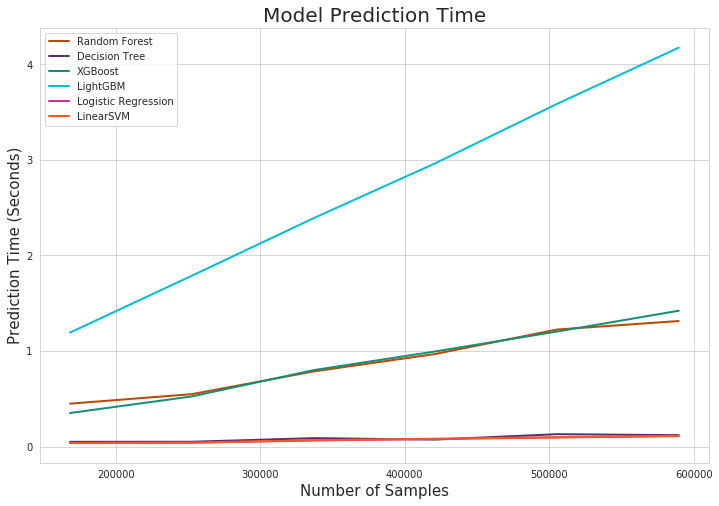

In [96]:
sns.set_style('whitegrid')

plt.figure(figsize=(12,8))
ax = sns.lineplot(x=rf_lengths, y=rf_times, color='#BA4A00', label='Random Forest', linewidth=2)
ax = sns.lineplot(x=dt_lengths, y=dt_times, color='#5B2C6F', label='Decision Tree', linewidth=2)
ax = sns.lineplot(x=xgb_lengths, y=xgb_times, color='#148F77', label='XGBoost', linewidth=2)
ax = sns.lineplot(x=lgb_lengths, y=lgb_times, color='#00BCD4', label='LightGBM', linewidth=2)
ax = sns.lineplot(x=log_lengths, y=log_times, color='#DC2990', label='Logistic Regression', linewidth=2)
ax = sns.lineplot(x=svc_lengths, y=svc_times, color='#FF5722', label='LinearSVM', linewidth=2)
ax.set_xlabel('Number of Samples', size=15);
ax.set_ylabel('Prediction Time (Seconds)', size=15);
ax.set_title('Model Prediction Time', size=20);
plt.savefig('prediction_time', bbox_inches ='tight', dpi = 400)

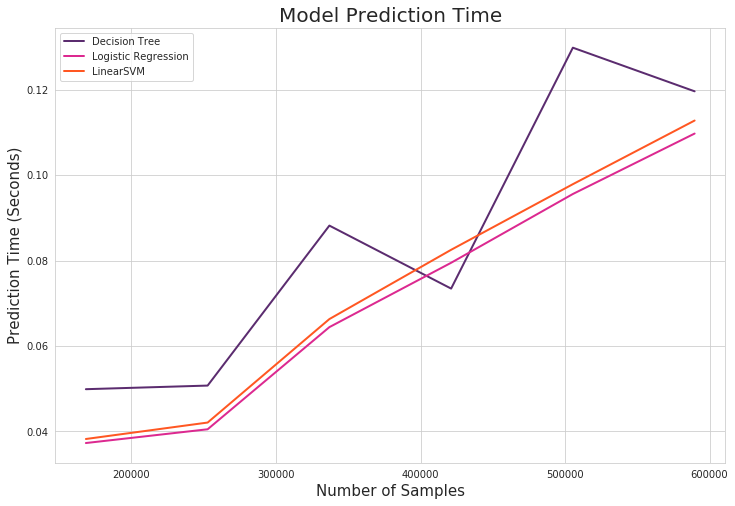

In [97]:
sns.set_style('whitegrid')

plt.figure(figsize=(12,8))
ax = sns.lineplot(x=dt_lengths, y=dt_times, color='#5B2C6F', label='Decision Tree', linewidth=2)
ax = sns.lineplot(x=log_lengths, y=log_times, color='#DC2990', label='Logistic Regression', linewidth=2)
ax = sns.lineplot(x=svc_lengths, y=svc_times, color='#FF5722', label='LinearSVM', linewidth=2)
ax.set_xlabel('Number of Samples', size=15);
ax.set_ylabel('Prediction Time (Seconds)', size=15);
ax.set_title('Model Prediction Time', size=20);
plt.savefig('prediction_time2', bbox_inches ='tight', dpi = 400)

In [90]:
rf_lengths

[168474, 252711, 336948, 421185, 505422, 589659]